James Jensen
---
hw1
---

In [ ]:
# Load necessary packages
import pandas as pd
import json
import requests
from pandas.io.json import json_normalize
from uszipcode import SearchEngine
import dateutil.parser
search = SearchEngine(simple_zipcode=True)

In [4]:
# Get data from Chicago Open Data Portal
r = requests.get("https://data.cityofchicago.org/resource/6zsd-86xi.json?$where=year BETWEEN '2017' AND '2018'&$limit=600000")
data = r.json()
full_df = pd.DataFrame.from_dict(json_normalize(data), orient='columns')

In [5]:
def date_convert(string): 
    '''
    Converts datetime string into month, day, year format
        Inputs: datetime string
    '''
    d = dateutil.parser.parse(string)

    return d.strftime('%m/%d/%Y')

In [6]:
# Sets datatypes to numberic so that you can get zipcodes from lat long
# Uses uszipcode library to convert lat long into zipcodes
# Creates df_with_zipcodes dataframe, which has a zipcode for every block

full_df[['latitude','longitude']] = full_df[['latitude','longitude']].apply(pd.to_numeric)
df_get_zipcodes = full_df.dropna(subset=['location.coordinates'])
df_get_zipcodes = df_get_zipcodes.drop_duplicates(subset=['block'])
df_get_zipcodes['zipcode'] = df_get_zipcodes.apply(lambda x: search.by_coordinates(x['latitude'], x['longitude'])[0].zipcode, axis=1)
df_with_zipcodes = df_get_zipcodes.loc[:,['block','zipcode']]


In [8]:
# Creates df_with_zip, a dataframe that includes a zipcode for every row from Chicago Open Data portal dataframe
df_with_zip = pd.merge(full_df, df_with_zipcodes, on='block', how='left')
df_with_zip['date'] = df_with_zip['date'].apply(lambda x: date_convert(x))
df_with_zip['date'] = pd.to_datetime(df_with_zip['date'])

#### 1.2

In [318]:
## create counts dataframe, which has count 
df_with_counts = df_with_zip.groupby(['zipcode','primary_type']).size().unstack().fillna(0)
df_with_counts

primary_type,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,GAMBLING,...,OTHER NARCOTIC VIOLATION,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
zipcode,,,,,,,,,,,,,,,,,,,,,
46327,0.0,19.0,50.0,18.0,0.0,3.0,45.0,1.0,13.0,0.0,...,0.0,23.0,0.0,0.0,1.0,6.0,0.0,0.0,41.0,13.0
46394,1.0,35.0,95.0,17.0,0.0,1.0,63.0,11.0,27.0,0.0,...,0.0,35.0,0.0,0.0,3.0,9.0,0.0,0.0,73.0,10.0
60018,0.0,94.0,230.0,1.0,43.0,1.0,74.0,229.0,412.0,0.0,...,0.0,81.0,0.0,0.0,29.0,1.0,8.0,0.0,837.0,15.0
60068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60106,0.0,2.0,3.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0
60131,0.0,6.0,2.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0
60171,0.0,0.0,5.0,1.0,0.0,1.0,3.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0
60176,1.0,9.0,24.0,1.0,3.0,1.0,7.0,3.0,9.0,0.0,...,0.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,32.0,1.0
60202,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


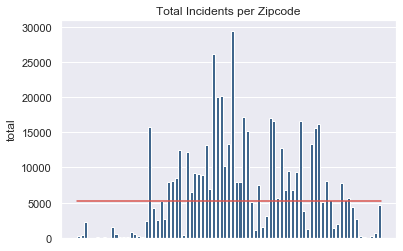

In [312]:
## Number of Crimes of Each Type
## Includes line marking the median number of incidents
total_crime_per_zip = df_with_counts.sum(axis=1).to_frame('total').reset_index()
ax = sns.barplot(x ='zipcode', y='total', data=total_crime_per_zip, color=(0.2, 0.4, 0.6, 0.6))
ax.axes.get_xaxis().set_visible(False)
ax.set_title("Total Incidents per Zipcode")
med = total_crime_per_zip['total'].median()
x = ax.axes.get_xlim()
ax.plot(x, len(x) * [med], sns.xkcd_rgb["pale red"])

In [313]:
total_crime_per_zip[total_crime_per_zip['total'] > (4*med)].sum()['total']/ total_crime_per_zip.sum()['total']

0.10388290455111228

In [214]:
# Summary of total crime per zipcode
total_crime_per_zip['total'].describe()

count       81.000000
mean      6595.864198
std       6610.179600
min          2.000000
25%        674.000000
50%       5167.000000
75%       9414.000000
max      29430.000000
Name: total, dtype: float64

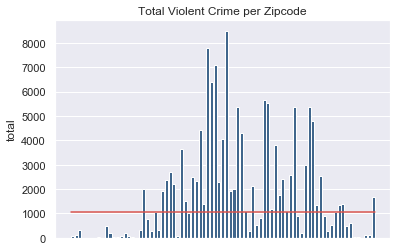

In [315]:
total_violent_per_zip = df_with_counts.loc[:,['ASSAULT','BATTERY', 'CRIM SEXUAL ASSAULT','HOMICIDE']].sum(axis=1).to_frame('total').reset_index()
ax = sns.barplot(x ='zipcode', y='total', data=total_violent_per_zip, color=(0.2, 0.4, 0.6, 0.6))
ax.axes.get_xaxis().set_visible(False)
ax.set_title("Total Violent Crime per Zipcode")
med = total_violent_per_zip['total'].median()
x = ax.axes.get_xlim()
ax.plot(x, len(x) * [med], sns.xkcd_rgb["pale red"])

In [322]:
## Outliers 
# With a standard deviation of nearly double the median and with 12 zipcodes that have values for total violent crime
# that are 4x the median, average violent crime in Chicago is clearly driven by a outliers. 
tot = (len(total_violent_per_zip[total_violent_per_zip['total'] > (4*med)]))
per = (total_violent_per_zip[total_violent_per_zip['total'] > (4*med)].sum()['total']/ total_violent_per_zip.sum()['total'])*100
print('{} zipcodes account for {} percent of all violent crime.'.format(tot, per))

12 zipcodes account for 49.28938087090128 percent of all violent crime.


In [229]:
## Summary of violent crime per zipcode
total_violent_per_zip.describe()

count      81.000000
mean     1767.716049
std      2046.861239
min         0.000000
25%       197.000000
50%      1053.000000
75%      2417.000000
max      8496.000000
dtype: float64

In [132]:
## Get census data
response = requests.get('https://api.census.gov/data/2017/acs/acs5?get=B15003_017E,B01003_001E,B17001_002E,B10050_003E,B02009_001E&for=zip code tabulation area:*')
data = response.json()
census_df = pd.DataFrame(data[1:], columns=data[0])

In [133]:
## clean and structure census data
codes = {
    'B15003_017E': 'educ',
    'B01003_001E': 'pop',
    'B17001_002E': 'total_below_poverty',
    'B10050_003E': 'total_with_grandparents',
    'B02009_001E': 'total_black_pop',
    'zip code tabulation area': 'zipcode'
}

census_df.columns = [codes[col] for col in census_df.columns]
## merge with counts
merged_df = pd.merge(df_with_counts, census_df, on='zipcode', how='inner')

for col in merged_df.columns: 
    merged_df[col] = pd.to_numeric(merged_df[col])

In [179]:
## Calculate rates
chars = ['educ','total_below_poverty','total_with_grandparents', 'total_black_pop']
for col in chars:
    name = col + '_rate'
    merged_df[name] = (merged_df[col]/merged_df['pop'])

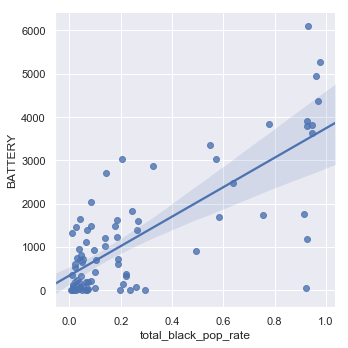

In [299]:
sns.lmplot(x="total_black_pop_rate", y="BATTERY", data=merged_df)

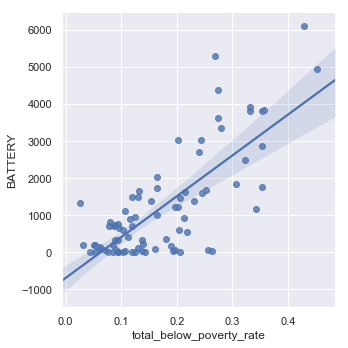

In [300]:
ax = sns.lmplot(x="total_below_poverty_rate", y="BATTERY", data=merged_df)

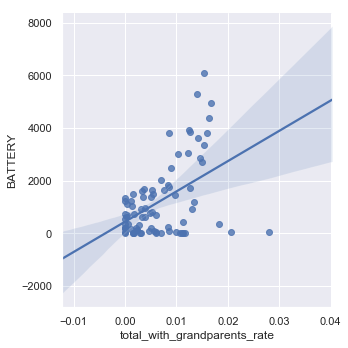

In [301]:
ax = sns.lmplot(x="total_with_grandparents_rate", y="BATTERY", data=merged_df)

#### 2.1
As we can see from the above plots, more incidents of battery occur in populations that have a larger black population, larger percentage of population living below the poverty level, and that have larger percentage of individuals living with their grandparents and without a parent. It should be noted that these plots identify a positive correlation between each variable and the total incidents of battery, not a causal relationship. 

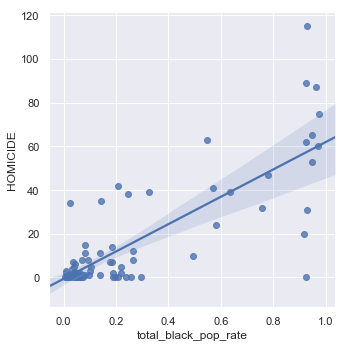

In [302]:
sns.lmplot(x="total_black_pop_rate", y="HOMICIDE", data=merged_df)

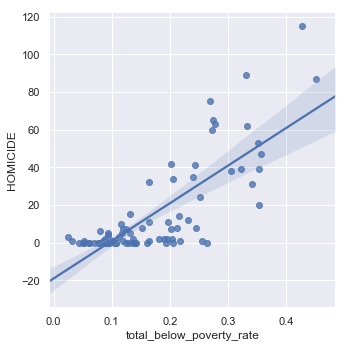

In [303]:
ax = sns.lmplot(x="total_below_poverty_rate", y="HOMICIDE", data=merged_df)

#### 2.2 - 2.3
As we can see from the above plots, in addition to seeing higher total counts of battery, populations that have a larger black population and larger percentage of population living below the poverty level also see a higher count of homicide. Given that both fall into the larger bucket of violent crime, it is not entirely surprising to see areas with high levels of each crime share similar characterisitics. Poverty rate and racial breakdown maintain a strong positive correlation with total incidents of battery and homicide over the time period analyzed (2017 and 2018). 

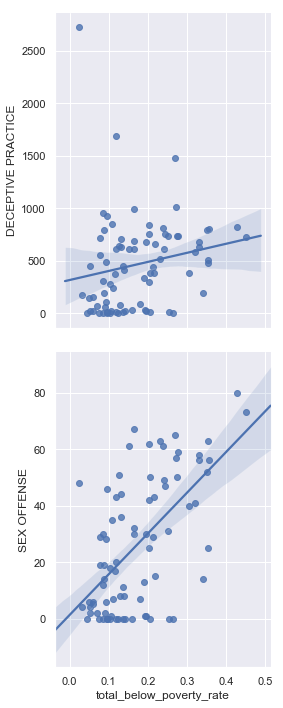

In [309]:
sns.pairplot(merged_df, x_vars=["total_below_poverty_rate"], y_vars=["DECEPTIVE PRACTICE", "SEX OFFENSE"],
             height=5, aspect=.8, kind="reg")

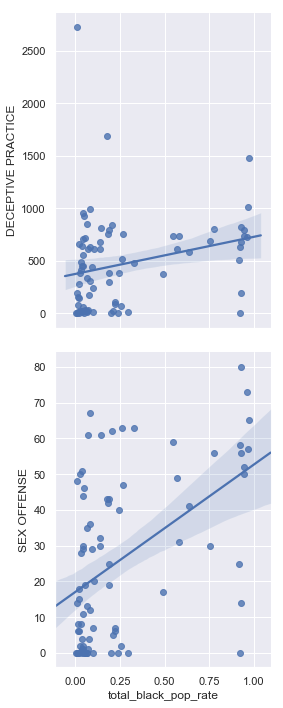

In [311]:
sns.pairplot(merged_df, x_vars=["total_black_pop_rate"], y_vars=["DECEPTIVE PRACTICE", "SEX OFFENSE"],
             height=5, aspect=.8, kind="reg")

#### 2.4
While there appears to be a strong positive relationship between the rate of the population living below the poverty level and the number of sex offenses, the same relationship does not exist between number of deceptive pracities and poverty rate -- while it is still positive, more likely to see deceptive practice across income levels. 

The same type of relationship exists between the number of sex offenses and black population rate in a given area -- we observe a strong relationship between sex offense and black population rate, while deceptive practice is more widespread across racial breakdown for a given zipcode. 

#### 3

In [14]:
# Problem 3 
df_per_month = df_with_zip.set_index('date').groupby(pd.Grouper(freq='M')).size()
incidents_df = pd.DataFrame({'date':df_per_month.index, 'count':df_per_month.values})
## Total Counts of Incidents per Month 

incidents_df['month'] = incidents_df['date'].apply(lambda x: x.month)
incidents_df['year'] = incidents_df['date'].apply(lambda x: x.year)

Text(0.5, 1.0, 'Total Incidents per Month')

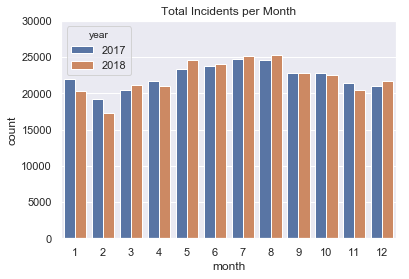

In [19]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.barplot(x='month', y='count', data=incidents_df, hue='year')
ax.set_ylim(bottom=0, top=30000)
ax.set_title("Total Incidents per Month")

In [127]:
total_year = incidents_df.groupby('year').sum()['count']
pct_change = ((total_year[2018] - total_year[2017])/ total_year[2017])*100
pct_change


-0.6583217085779505

#### 3.1 
With a change in total crime of -0.66%, overall, crime has decreased by .66% from 2017 to 2018. 

In [84]:
## Determine number of months where crime was lower in 2018 than 2017. 
tot = 0
for name, group in incidents_df.groupby(['month']):
    if (group.iloc[0]['count'] > group.iloc[1]['count']):
        tot += 1
## 5 months in 2018 had total lower crime counts than 2017. 



#### 3.2

In [112]:
# CREATE dataframe filtered on ward 43, July, and the day of the month to answer question 3
import datetime
full_df_3 = df_with_zip[(df_with_zip['ward'] == '43') & ((df_with_zip['date'].dt.month ==7) & (df_with_zip['date'].dt.day <27))]


In [113]:
df_3 = full_df_3.groupby(['year', 'primary_type']).size().unstack()


primary_type,ASSAULT,BATTERY,BURGLARY,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,INTERFERENCE WITH PUBLIC OFFICER,KIDNAPPING,LIQUOR LAW VIOLATION,MOTOR VEHICLE THEFT,NARCOTICS,NON-CRIMINAL,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,THEFT,WEAPONS VIOLATION
year,,,,,,,,,,,,,,,,,,,,
2017,5.0,38.0,14.0,2.0,24.0,7.0,30.0,1.0,2.0,NaN,6.0,1.0,1.0,2.0,4.0,1.0,15.0,5.0,153.0,NaN
2018,15.0,30.0,14.0,NaN,25.0,16.0,31.0,NaN,NaN,2.0,10.0,1.0,NaN,1.0,13.0,1.0,8.0,5.0,173.0,2.0


In [320]:
# 3.2
print(((df_3.loc['2018','ROBBERY']-df_3.loc['2017','ROBBERY'])/df_3.loc['2017','ROBBERY'])*100, 'percentage change in robbery from 2017 to 2018')
print(((df_3.loc['2018','BURGLARY']-df_3.loc['2017','BURGLARY'])/df_3.loc['2017','BURGLARY'])*100, 'percentage change in burglary from 2017 to 2018')
print(((df_3.loc['2018','MOTOR VEHICLE THEFT']-df_3.loc['2017','MOTOR VEHICLE THEFT'])/df_3.loc['2017','MOTOR VEHICLE THEFT'])*100, 'percentage change in motor vehicle theft from 2017 to 2018')
print(((full_df_3.groupby(['year']).size()['2018'] - full_df_3.groupby(['year']).size()['2017']) / full_df_3.groupby(['year']).size()['2017'])*100, 'percentage change in total crime from 2017 to 2-18')

-46.666666666666664 percentage change in robbery from 2017 to 2018
0.0 percentage change in burglary from 2017 to 2018
66.66666666666666 percentage change in motor vehicle theft from 2017 to 2018
11.57556270096463 percentage change in total crime from 2017 to 2-18


In [166]:
# 3.3
by_type_2017 = df_with_zip[df_with_zip['year']== '2017'].groupby('primary_type').size().sort_values(ascending=False)
by_type_2018 = df_with_zip[df_with_zip['year']== '2018'].groupby('primary_type').size().sort_values(ascending=False)
(((by_type_2018 - by_type_2017)/ by_type_2017)*100).sort_values(ascending=False)

In [175]:
# Percentage change in crime from 2017 to 2018 
(((by_type_2018 - by_type_2017)/ by_type_2017)*100).sort_values(ascending=False)

primary_type
CONCEALED CARRY LICENSE VIOLATION    115.942029
HUMAN TRAFFICKING                     55.555556
NON-CRIMINAL (SUBJECT SPECIFIED)      50.000000
LIQUOR LAW VIOLATION                  40.314136
PUBLIC INDECENCY                      40.000000
INTERFERENCE WITH PUBLIC OFFICER      20.165746
WEAPONS VIOLATION                     16.303884
NARCOTICS                             11.631498
INTIMIDATION                          11.258278
STALKING                               7.978723
SEX OFFENSE                            7.707317
ASSAULT                                5.563902
GAMBLING                               5.235602
CRIMINAL TRESPASS                      1.335682
BATTERY                                1.150056
THEFT                                  1.146907
CRIM SEXUAL ASSAULT                    0.061425
OTHER OFFENSE                         -0.539850
OBSCENITY                             -1.149425
DECEPTIVE PRACTICE                    -1.450037
OFFENSE INVOLVING CHILDREN 

In [177]:
(((by_type_2018 - by_type_2017))).sort_values(ascending=False)

primary_type
NARCOTICS                            1356
ASSAULT                              1074
WEAPONS VIOLATION                     764
THEFT                                 738
BATTERY                               566
INTERFERENCE WITH PUBLIC OFFICER      219
CRIMINAL TRESPASS                      91
CONCEALED CARRY LICENSE VIOLATION      80
SEX OFFENSE                            79
LIQUOR LAW VIOLATION                   77
INTIMIDATION                           17
STALKING                               15
GAMBLING                               10
HUMAN TRAFFICKING                       5
PUBLIC INDECENCY                        4
NON-CRIMINAL (SUBJECT SPECIFIED)        1
CRIM SEXUAL ASSAULT                     1
NON-CRIMINAL                           -1
OBSCENITY                              -1
OTHER NARCOTIC VIOLATION              -10
PROSTITUTION                          -17
KIDNAPPING                            -21
OFFENSE INVOLVING CHILDREN            -37
ARSON                

#### 3.2.a 
No, these statistics are not correct. For Ward 43 over the same number of days in July from 2017 to 2018, I found that robbery is down 46%, the number of burglaries have not changed, and that motor vehicle theft has actually increased by 66%. All told, crime is up 11% for Ward 43 over the same time period and crime is down .66% for all of Chicago. 

#### 3.2.b 
I find the candidate's conclusions to be misleading. While there seems to be agreement in general trend for some instances of crime between my analysis and the alderman's (Motor Vehicle Theft and Total Crime Rate), I disagree with both the magnitude and direction for both the change in burglaries and robbery between 2017 and 2018. This leads be to believe that it's possible the candidate is switching between crime stats specifically for the 43rd ward and stats for all of Chicago when it supports his argument. It's also possible that the candidate is using multiple data sources. The [crime statistics](https://home.chicagopolice.org/wp-content/uploads/2019/04/22_PDFsam_CompStat-Public-2019-Week-14.pdf) on the Chicago Police Department's website releases reports with total counts per week, starting on the first day of the week. If the candidate is using this as his source, instead of using the city's open data portal, it's possible that the candidate is improperly comparing two different time periods. 

#### 3.3
1. 12 zipcodes account for nearly 50% of all violent crime from 2017 to 2018. Given that it's so highly concentrated, the most effective strategy would be to focus majority of resources on these neighborhoods. 

2.  Violent crime is positively correlated with the percentage of population that identifies as black. While the mayor should absolutely place a stronger emphasis on community policing, this effort should be in tandem with and support organizations working in areas with high rates of violent crime so that (1) the police gain the trust of the public, and (2) are best positioned to communicate and connect with the public. 

3. We haven't seen a significant change in total crime between 2017 and 2018 (only .66% decrease) and we know that violent crime is positively correlated with the percentage of population below the poverty rate. Given that a precipitous drop with a quick turnaround is unlikely, while not banner or slogan worthy, the mayor's approach should focus on long-term crime reduction, not a quick-fix bandaid. Any use of police intervention should be accompanied with a sustainable plan that focuses on systemic issues that keep these neighborhoods in poverty.

4. When thinking about where to allocate resources, one strategy could focus on where we see the greatest percentage increase from the year before. The top three largest percentage increases from 2017 to 2018 were, (1) CONCEALED CARRY LICENSE VIOLATION, 115% increase; (2) HUMAN TRAFFICKING, 55% increase; and (3) LIQUOR LAW VIOLATION, at 40% increase.

5. The Mayor could also focus curbing the largest absolute increases in crime, which were narcotics related offenses (1356), assault (1074), and weapons violations (764)

#### 3.4 

This analysis lacks any understanding on recidivism rates and how much of the crime is done by repeat offenders. It also does not take into account any of the current approaches taken by the Chicago Police Department, the Mayor's Office, the State's Attorney's Office, or any activist/non-profit groups. Without understanding a better understanding of who is committing the crime and the impact of prior approaches to reduce it, I'm unable to make strong recommendations. 


#### 4.A 
Since I did not have the exact block for 2111 S Michigan Ave, I used zipcode as a proxy. Given the call came from 60616, the most likely crime type is Theft (27.3%). 


In [317]:
# 4.A
max_prob = df_with_zip[df_with_zip['zipcode'] == '60616'].groupby(
    'primary_type').size().apply(
    lambda x: x / df_with_zip[df_with_zip['zipcode'] == '60616'].
    groupby('primary_type').size().sum()).to_frame('likelihood')

max_prob.loc[max_prob['likelihood'].idxmax()]

likelihood    0.273186
Name: THEFT, dtype: float64

In [208]:
theft_df = df_with_zip[df_with_zip['primary_type'] == 'THEFT']

In [215]:
theft = len(theft_df.index)
garfield_and_theft = df_with_zip[(df_with_zip['primary_type'] == 'THEFT') & (df_with_zip['community_area'].isin(['26','27']))].groupby('community_area').size().sum()
uptown_and_theft = df_with_zip[(df_with_zip['primary_type'] == 'THEFT') & (df_with_zip['community_area'].isin(['3']))].groupby('community_area').size().sum()

In [219]:
prob_uptown = uptown_and_theft/theft
prob_garfied = garfield_and_theft/theft

In [220]:
prob_uptown

0.015097196897116543

In [221]:
prob_garfied

0.01926940074790617

#### 4.B
If a call comes in about theft, it is .4 percentage points more likely to come from Garfield.


#### 4.C 
If a call comes about Battery, there's a 38% chance it's from Garfield and a 62% chance its from Uptown, so it's 24 percentage points more likely to be from Uptown. 
P(Garfield | Battery) = 100/260 = .38
P(Uptown | Battery) = 160/260 = .615